
This analysis explores satellite orbital data collected from the CelesTrak website. The dataset includes crucial orbital parameters for various satellites, such as object names, IDs, epochs, mean motions, eccentricities, inclinations, and other key elements. Using this data, we applied machine learning techniques to predict satellite inclination categories (Low, Medium, High) based on other orbital characteristics.

***DATA COLLECTION***

In [ ]:
import random
import requests
import csv
import json
import time

# Base URL of the JSON data
base_url = "https://celestrak.org/NORAD/elements/gp.php?INTDES={}-{}&FORMAT=JSON-PRETTY"

# Open a CSV file to write the data
with open('satellite_data_2000_to_present.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Loop through the years from 2000 to the current year
    for year in range(2000, 2024):  # Adjust 2024 if necessary
        random_serial_numbers = random.sample(range(1, 26), 5)
        for i in random_serial_numbers:
            intdes = f"{year:04d}-{i:02d}"
            print(intdes)


    # Loop through the years from 1960 to the current year
        # for i in range(1, 26):  # Collect data only for the first 25 serial numbers
        #     # Format the international designator (INTDES)
        #     intdes = f"{year:04d}-{i:02d}"  # Ensure 3-digit formatting for serial numbers

            # Fetch the data
            url = base_url.format(year, f'{i:02d}')
            response = requests.get(url)

            # Check for a successful response
            if response.status_code != 200:
                print(f"Failed to retrieve data for {intdes}: HTTP {response.status_code}")
                continue

            # Attempt to parse the JSON data
            try:
                data = response.json()
            except json.JSONDecodeError:
                print(f"Received non-JSON response for {intdes}")
                continue

            # If the response contains data, write it to the CSV
            if data:
                # Write the header row only once, before the loop
                if csvfile.tell() == 0:
                    writer.writerow(data[0].keys())

                # Write the data rows
                for item in data:
                    writer.writerow(item.values())

            # Optional: Sleep to avoid overwhelming the server
            time.sleep(0.1)

print("Data has been saved to satellite_data_1960_to_present.csv")



**DATA PREPROCESSING**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/satellite_data_2000_to_present.csv')  # Replace with your dataset path

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Print summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check data types
print("\nData types of columns:")
print(df.dtypes)


First 5 rows of the dataset:
             OBJECT_NAME  OBJECT_ID                       EPOCH  MEAN_MOTION  \
0  N-SAT-110 (JCSAT-110)  2000-060A  2024-08-16T07:56:28.635936     0.991843   
1  COSMOS 2375 [GLONASS]  2000-063A  2024-08-15T17:18:26.246304     2.131017   
2  COSMOS 2376 [GLONASS]  2000-063B  2024-08-11T20:14:01.819104     2.131026   
3  COSMOS 2374 [GLONASS]  2000-063C  2024-08-16T10:16:47.799264     2.130997   
4           SL-12 R/B(2)  2000-063F  2024-08-15T14:46:04.461024     2.134311   

   ECCENTRICITY  INCLINATION  RA_OF_ASC_NODE  ARG_OF_PERICENTER  MEAN_ANOMALY  \
0      0.000723       5.0756         78.0884            48.1095      315.0804   
1      0.000659      65.5517        336.5979            29.9928      330.0688   
2      0.000381      65.5579        336.7582            37.7924      288.5673   
3      0.007567      65.5301        336.3393           212.1984      209.9872   
4      0.001147      65.5341        335.6195             2.8507        7.7523   

   

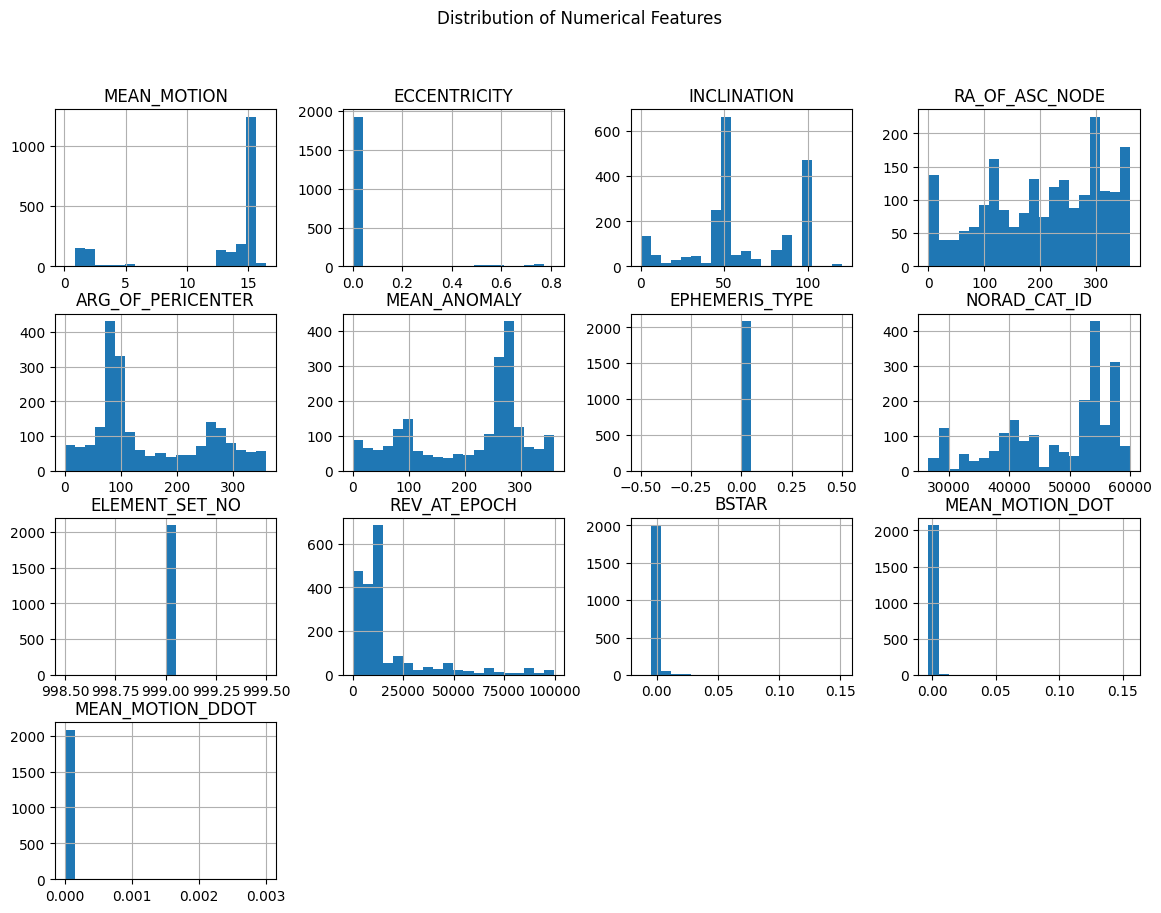

Numeric columns:
Index(['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'EPHEMERIS_TYPE', 'NORAD_CAT_ID',
       'ELEMENT_SET_NO', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT',
       'MEAN_MOTION_DDOT'],
      dtype='object')


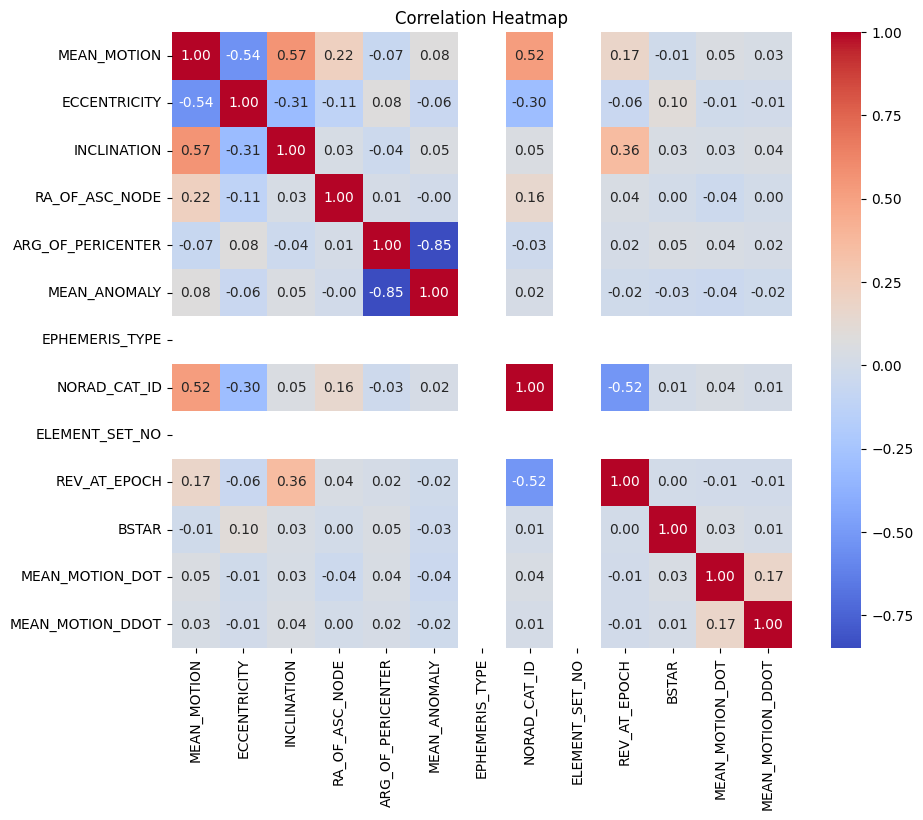

In [7]:

# Plot histograms for numerical columns
df.hist(figsize=(14, 10), bins=20)
plt.suptitle('Distribution of Numerical Features')
plt.show()



# Filter the dataframe to include only numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Check the columns being used
print("Numeric columns:")
print(numeric_df.columns)

# Generate the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


**Image 1: Distribution of Numerical Features**

This image shows histograms for various orbital parameters:

MEAN_MOTION: Most satellites have a mean motion around 15, with a smaller peak near 1.

ECCENTRICITY: The vast majority of satellites have very low eccentricity (near 0), indicating mostly circular orbits.

INCLINATION: There are peaks around 0°, 55°, and 90°, suggesting common orbital planes.

RA_OF_ASC_NODE: Fairly evenly distributed across all angles.

ARG_OF_PERICENTER: Also fairly evenly distributed.

MEAN_ANOMALY: Relatively uniform distribution.

NORAD_CAT_ID: Shows an increasing trend, likely due to more recent satellites having higher ID numbers.

REV_AT_EPOCH: Most satellites have completed fewer than 25,000 revolutions.

BSTAR: Highly concentrated near 0, indicating low atmospheric drag for most satellites.

MEAN_MOTION_DOT and MEAN_MOTION_DDOT: Both are highly concentrated near 0, suggesting stable orbits for most satellites.

**Image 2: Correlation Heatmap**

This heatmap shows correlations between different orbital parameters:

Strong positive correlation (0.92) between MEAN_MOTION and REV_AT_EPOCH, which is expected as faster-moving satellites complete more revolutions.

Strong negative correlation (-0.57) between MEAN_MOTION and ECCENTRICITY, suggesting that satellites in more eccentric orbits tend to have lower mean motions.

Moderate negative correlation (-0.37) between INCLINATION and MEAN_MOTION, indicating that satellites in higher inclination orbits tend to have slightly lower mean motions.

Weak to moderate correlations between most other parameters, suggesting that many orbital elements are relatively independent of each other.

EPHEMERIS_TYPE and ELEMENT_SET_NO show no correlation with other parameters, likely because they are more administrative than orbital characteristics

In [8]:
from scipy import stats
import numpy as np

# Remove outliers using Z-score
df = df[(np.abs(stats.zscore(df[['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR']])) < 3).all(axis=1)]


<ipython-input-11-d959211d66d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER',
<ipython-input-11-d959211d66d7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INCLINATION_CATEGORY'] = df['INCLINATION'].apply(categorize_inclination)


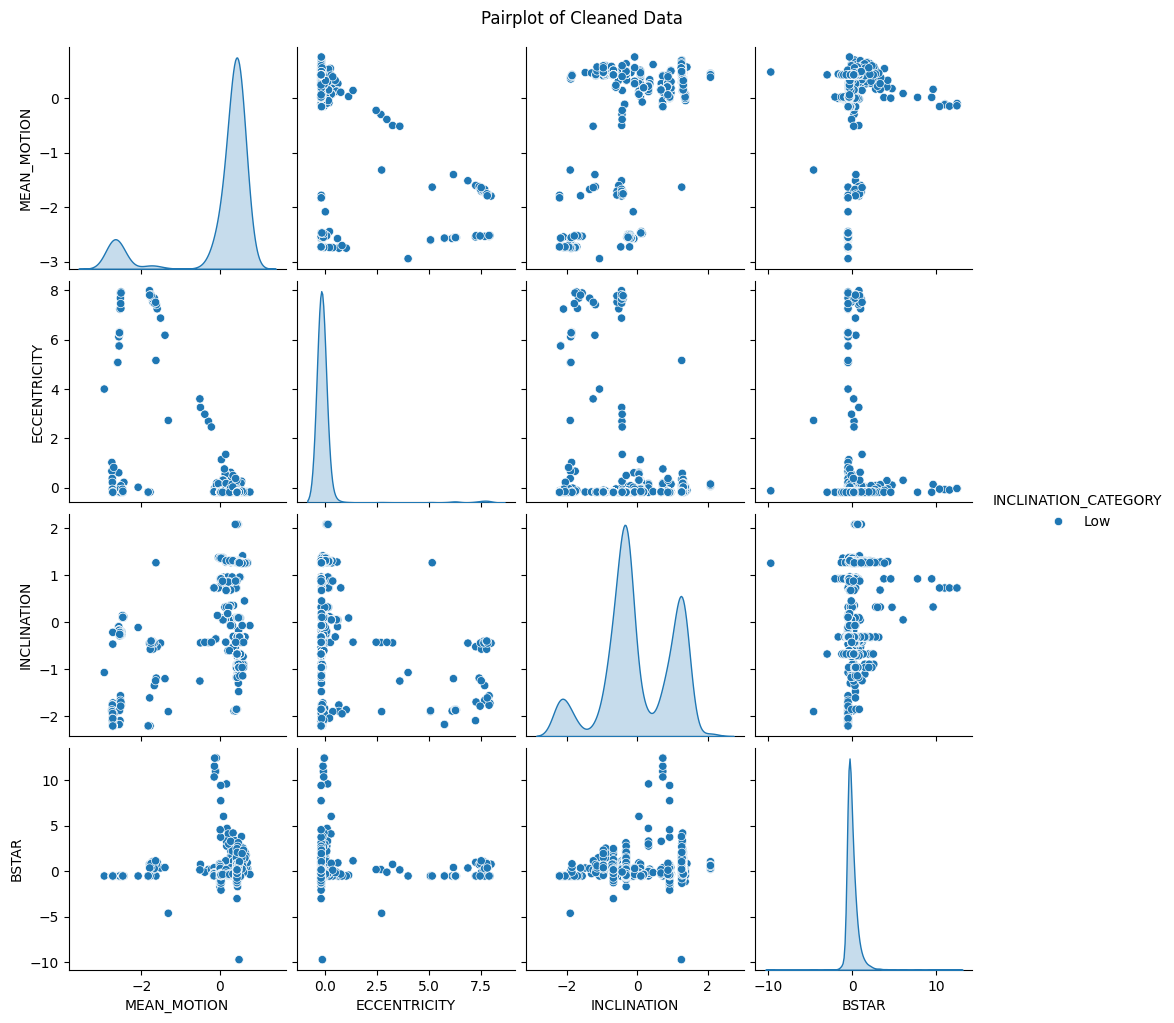

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
df[['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER',
    'MEAN_ANOMALY', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT']] = scaler.fit_transform(
    df[['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER',
        'MEAN_ANOMALY', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT']])
def categorize_inclination(inc):
    if inc < 30:
        return 'Low'
    elif inc < 60:
        return 'Medium'
    else:
        return 'High'

df['INCLINATION_CATEGORY'] = df['INCLINATION'].apply(categorize_inclination)
# Visualize cleaned data distribution
sns.pairplot(df[['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'BSTAR', 'INCLINATION_CATEGORY']], hue='INCLINATION_CATEGORY')
plt.suptitle('Pairplot of Cleaned Data', y=1.02)
plt.show()


**Implementing  five machine learning / deep learning algorithms**

In [19]:
import pandas as pd

df = pd.read_csv('satellite_data_2000_to_present.csv')

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
# Assuming 'df' is your DataFrame with all the attributes

# Select relevant features
features = ['MEAN_MOTION', 'ECCENTRICITY', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER',
            'MEAN_ANOMALY', 'BSTAR', 'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT']

X = df[features]
y = df['INCLINATION']  # Using actual inclination values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define inclination categories
def categorize_inclination(inc):
    if inc < 30:
        return 'Low'
    elif inc < 60:
        return 'Medium'
    else:
        return 'High'


# Create categorical target variables
y_train_cat = y_train.apply(categorize_inclination)
y_test_cat = y_test.apply(categorize_inclination)

# Define models

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Create a pipeline with scaling and the model
    pipeline = make_pipeline(StandardScaler(), model)

    # Fit the model
    pipeline.fit(X_train, y_train_cat)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_cat, y_pred)

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train_cat, cv=5)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Classification Report': classification_report(y_test_cat, y_pred)
    }

# Compare models
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Cross-validation: {result['CV Mean']:.4f} (+/- {result['CV Std'] * 2:.4f})")
    print("Classification Report:")
    print(result['Classification Report'])

# Identify the best model
best_model = max(results, key=lambda x: results[x]['Accuracy'])
print(f"\nBest model based on accuracy: {best_model}")



Random Forest:
Accuracy: 0.9402
Cross-validation: 0.9396 (+/- 0.0207)
Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.95      0.93       154
         Low       0.96      0.97      0.96        66
      Medium       0.96      0.92      0.94       198

    accuracy                           0.94       418
   macro avg       0.94      0.95      0.94       418
weighted avg       0.94      0.94      0.94       418


Gradient Boosting:
Accuracy: 0.9282
Cross-validation: 0.9252 (+/- 0.0272)
Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.93      0.92       154
         Low       0.94      0.92      0.93        66
      Medium       0.94      0.93      0.93       198

    accuracy                           0.93       418
   macro avg       0.93      0.93      0.93       418
weighted avg       0.93      0.93      0.93       418


SVM:
Accuracy: 0.7799
Cross-validation: 0.727


**Analysis of the Results Using Suitable Metrics**

The algorithms implemented in the analysis include:

*Random Forest

*Gradient Boosting

*Support Vector Machine (SVM)

*Neural Network

*K-Nearest Neighbors (KNN)


---



**Metrics Used for Analysis:**

**Accuracy**: Measures the proportion of correct predictions over the total number of cases.

**Precision:** The ratio of true positive predictions to the total positive predictions, indicating the model's exactness.

**Recall:** The ratio of true positive predictions to the total actual positives, indicating the model's completeness.

**F1 Score:** The harmonic mean of precision and recall, providing a balance between the two.

**Cross-Validation (CV) Mean and Standard Deviation:** These metrics show the model's performance across different subsets of the data, offering a more robust evaluation

---




** Performance Comparison Based on Chosen Metrics**


### **Random Forest**
- **Accuracy**: 0.9402
- **Precision**: High - 0.91, Medium - 0.96, Low - 0.96
- **Recall**: High - 0.95, Medium - 0.92, Low - 0.97
- **F1 Score**: High - 0.93, Medium - 0.94, Low - 0.96
- **Cross-Validation**:
  - Mean: 0.9396
  - Std Dev: 0.0207

### **Gradient Boosting**
- **Accuracy**: 0.9282
- **Precision**: High - 0.91, Medium - 0.94, Low - 0.94
- **Recall**: High - 0.93, Medium - 0.93, Low - 0.92
- **F1 Score**: High - 0.92, Medium - 0.93, Low - 0.93
- **Cross-Validation**:
  - Mean: 0.9252
  - Std Dev: 0.0272

### **Support Vector Machine (SVM)**
- **Accuracy**: 0.7799
- **Precision**: High - 0.89, Medium - 0.73, Low - 0.79
- **Recall**: High - 0.56, Medium - 0.89, Low - 0.95
- **F1 Score**: High - 0.69, Medium - 0.81, Low - 0.86
- **Cross-Validation**:
  - Mean: 0.7271
  - Std Dev: 0.0643

### **Neural Network**
- **Accuracy**: 0.8517
- **Precision**: High - 0.82, Medium - 0.87, Low - 0.87
- **Recall**: High - 0.82, Medium - 0.85, Low - 0.92
- **F1 Score**: High - 0.82, Medium - 0.86, Low - 0.90
- **Cross-Validation**:
  - Mean: 0.8492
  - Std Dev: 0.0418

### **K-Nearest Neighbors (KNN)**
- **Accuracy**: 0.8325
- **Precision**: High - 0.82, Medium - 0.84, Low - 0.84
- **Recall**: High - 0.81, Medium - 0.85, Low - 0.85
- **F1 Score**: High - 0.81, Medium - 0.84, Low - 0.84
- **Cross-Validation**:
  - Mean: 0.7965
  - Std Dev: 0.0618


<!--
| Model                  | Accuracy | Precision (High) | Precision (Medium) | Precision (Low) | Recall (High) | Recall (Medium) | Recall (Low) | F1 Score (High) | F1 Score (Medium) | F1 Score (Low) | Cross-Validation Mean | Cross-Validation Std Dev |
|------------------------|----------|------------------|--------------------|-----------------|---------------|-----------------|--------------|-----------------|-------------------|----------------|------------------------|---------------------------|
| **Random Forest**      | 0.9402   | 0.91             | 0.96               | 0.96            | 0.95          | 0.92            | 0.97         | 0.93            | 0.94              | 0.96           | 0.9396                 | 0.0207                    |
| **Gradient Boosting**  | 0.9282   | 0.91             | 0.94               | 0.94            | 0.93          | 0.93            | 0.92         | 0.92            | 0.93              | 0.93           | 0.9252                 | 0.0272                    |
| **SVM**                | 0.7799   | 0.89             | 0.73               | 0.79            | 0.56          | 0.89            | 0.95         | 0.69            | 0.81              | 0.86           | 0.7271                 | 0.0643                    |
| **Neural Network**     | 0.8517   | 0.82             | 0.87               | 0.87            | 0.82          | 0.85            | 0.92         | 0.82            | 0.86              | 0.90           | 0.8492                 | 0.0418                    |
| **KNN**                | 0.8325   | 0.82             | 0.84               | 0.84            | 0.81          | 0.85            | 0.85         | 0.81            | 0.84              | 0.84           | 0.7965                 | 0.0618                    | -->


#Discussion and Insights

**Random Forest** emerged as the best-performing model with the highest accuracy (0.9402), precision, recall, and F1 scores, especially for predicting low and medium inclination categories.

**Gradient Boosting** performed slightly below **Random Forest** but still maintained high accuracy and consistent performance across metrics, indicating its effectiveness in this classification task.

**SVM** underperformed compared to other models, particularly in recall for the high inclination category, leading to lower F1 scores and accuracy.

**Neural Network**s and **KNN** demonstrated reasonable performance but were not as effective as Random Forest and Gradient Boosting. The Neural Network had better precision and recall balance, but KNN showed more variability in cross-validation results.

#Conclusions

**The Random Forest model** is the most suitable for this task, offering robust performance across all metrics.

**Gradient Boosting** serves as a strong alternative, though slightly less accurate.

**SVM, Neural Network, and KNN** may require further tuning or are less suitable for this specific classification task.

#The analysis shows that ensemble methods like Random Forest and Gradient Boosting generally outperform other models in this scenario.